In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import squarify

ModuleNotFoundError: No module named 'pandas'

In [3]:
input_file = 'raw_data.csv'
output_file = 'processed_data.csv'

# Read, process, and write to a new CSV
with open(input_file, mode='r', encoding='utf-8') as infile, \
     open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    # Write the header
    writer.writerow(["Company", "Industry"])

    # Process each row
    for row in reader:
        entry = row[0].strip()  # Get the single column and strip whitespace
        if "|" in entry:
            company, industry = map(str.strip, entry.split('|'))
            writer.writerow([company, industry])

print(f"Data has been successfully processed and written to {output_file}")

Data has been successfully processed and written to processed_data.csv


In [44]:
# Load the data
filepath = 'processed_data.csv'  # Replace with the actual file path
df = pd.read_csv(filepath)

In [45]:
# Inspect the data
print(df.shape)
print(df.columns)
df.head(10)

(193, 2)
Index(['Company', 'Industry'], dtype='object')


,Company,Industry
0,#67,Telephone Utilities
1,46andMix,Other
2,A_Connect,Education
3,AA,Computer Software
4,Abstract,Internet
5,Adonis,Health
6,Ahonetwo,Business Services
7,AI HR APP,Computer Software
8,AIID,"Builders/Residential,Computer Software"
9,ANAKIN,Internet


In [46]:
df.describe()

,Company,Industry
count,193,193
unique,193,75
top,#67,Other
freq,1,32


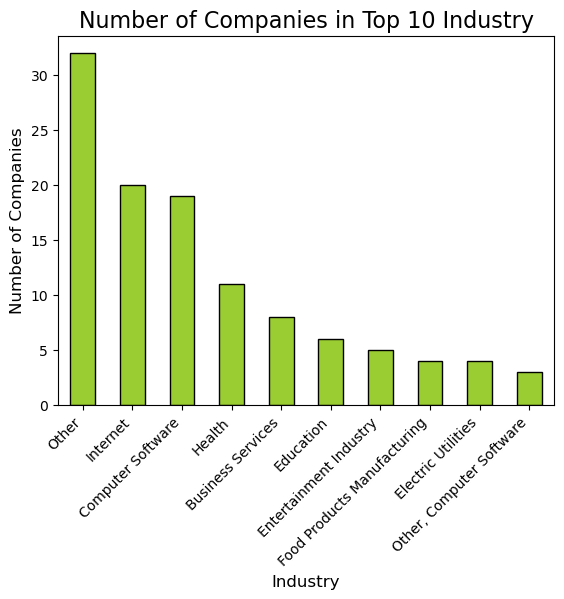

In [ ]:
# Bar chart showing the number of companies in top 10 industry
industry_counts_top10 = df['Industry'].value_counts().head(10)
industry_counts_top10.plot(kind='bar', color='yellowgreen', edgecolor='black')
plt.title('Number of Companies in Top 10 Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

Text(0, 0.5, '')

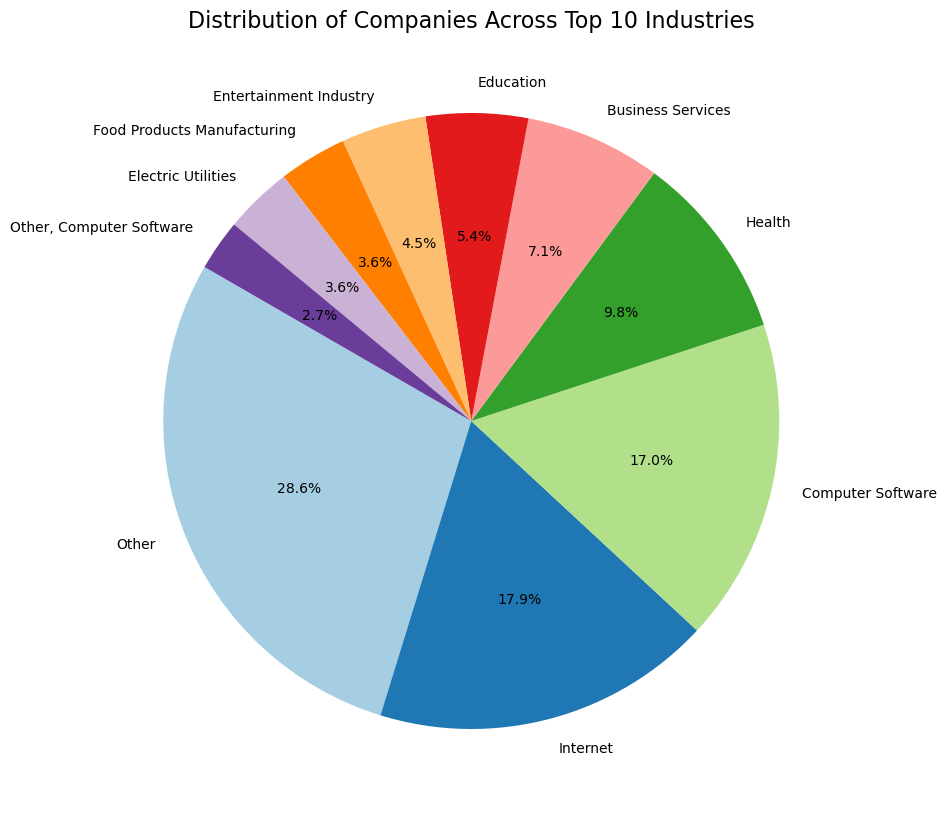

In [34]:
# Pie Chart: Percentage Distribution of Companies Across Industries
plt.figure(figsize=(10, 10))
industry_counts_top10.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=plt.cm.Paired.colors)
plt.title('Distribution of Companies Across Top 10 Industries', fontsize=16)
plt.ylabel('')  # Hides the y-label for the pie chart

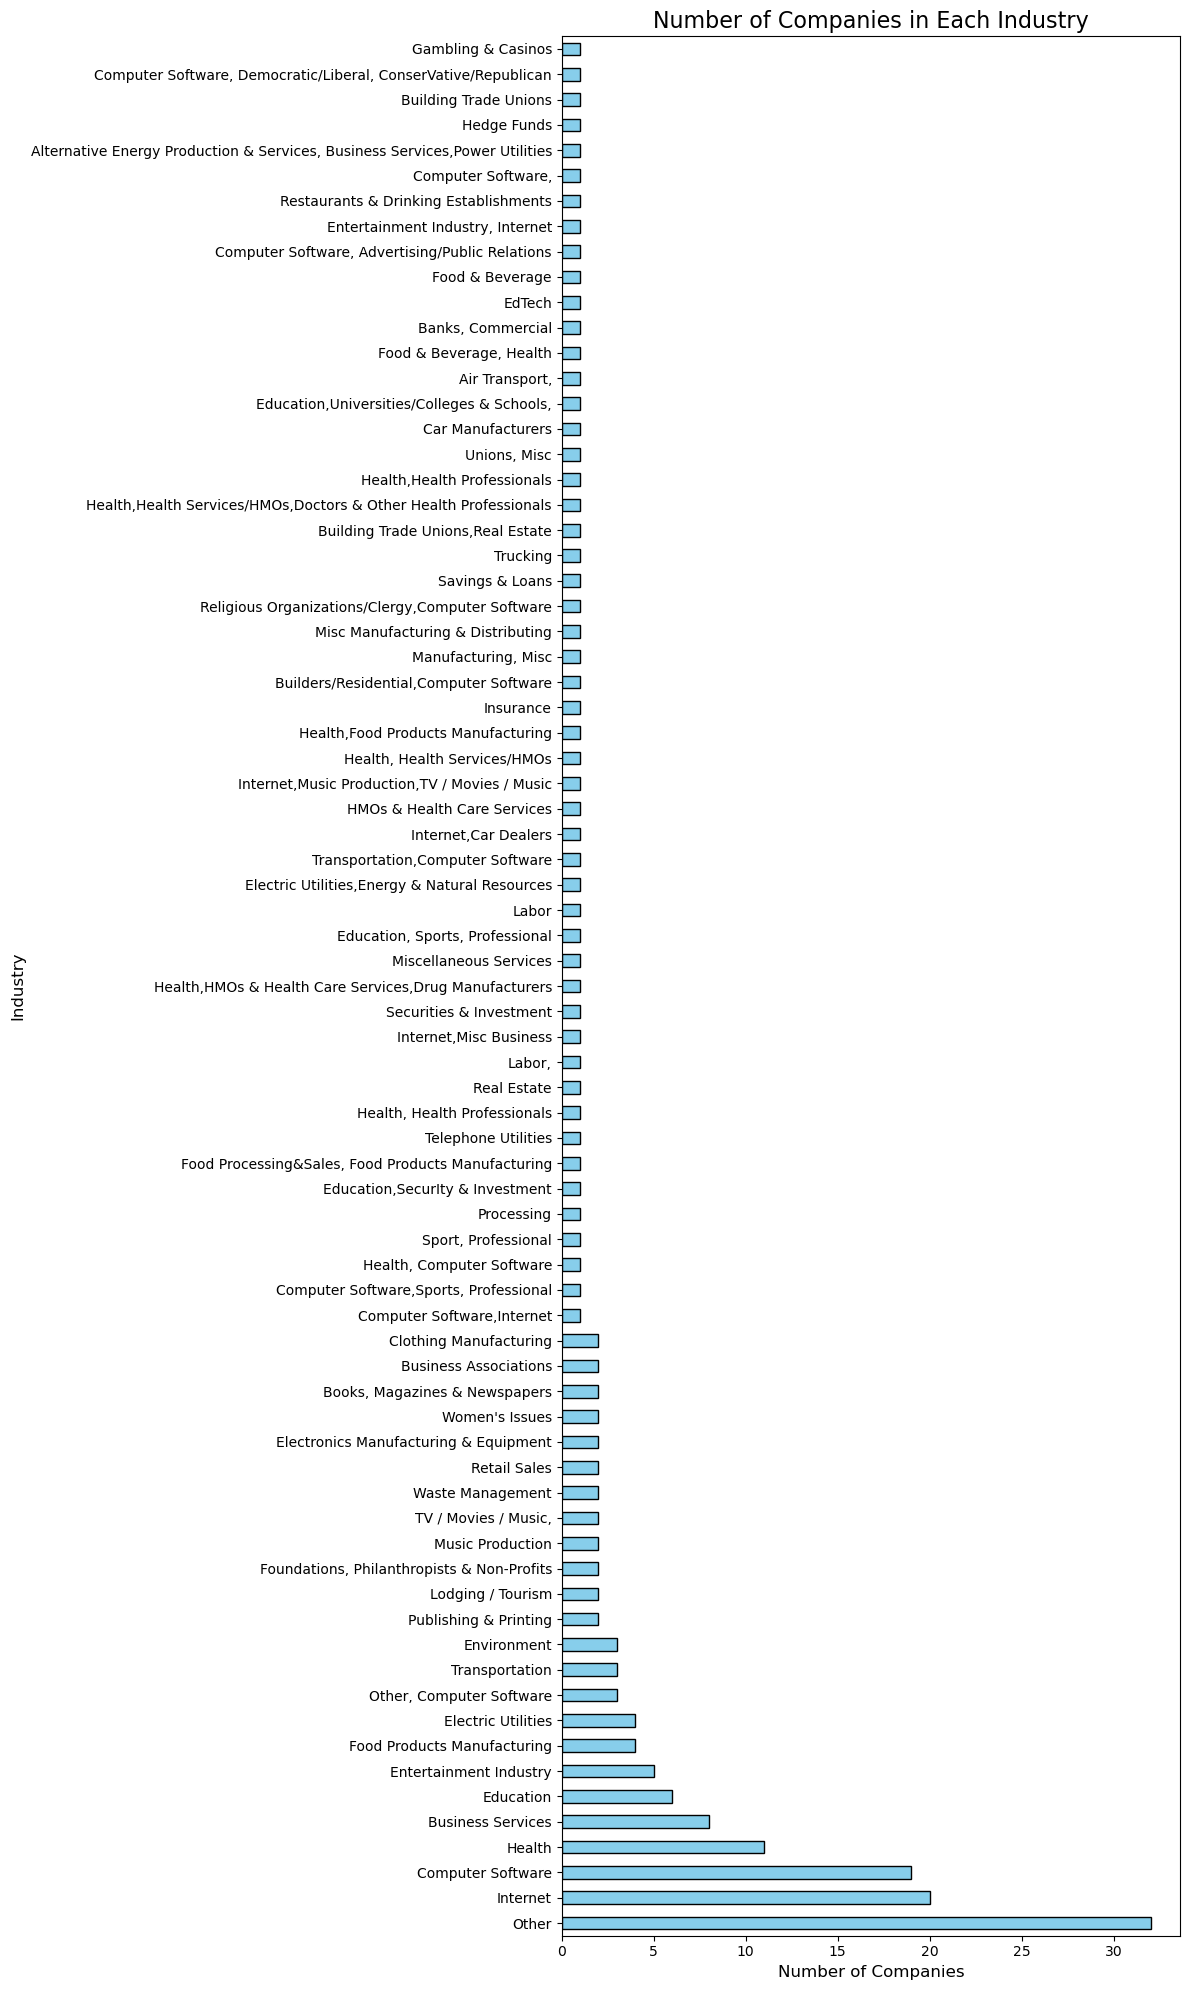

In [50]:
# Prepare data for treemap
industry_counts = df['Industry'].value_counts()
sizes = industry_counts.values
labels = industry_counts.index

# Treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.Paired.colors)
plt.title('Treemap of Industries by Number of Companies', fontsize=16)
plt.axis('off')  # Remove axes for a cleaner look